# 回帰問題でのDropoutの影響検証
## 背景・目的
回帰問題をNNで解くときにDropoutとBatchNormを使わない方が良いという話を聞いた。  
https://twitter.com/Tsultra_K/status/1421057421527506944  
https://towardsdatascience.com/pitfalls-with-dropout-and-batchnorm-in-regression-problems-39e02ce08e4d  

回帰問題でDropoutを使うことによる影響を検証し、その対策について検討する。  
(BatchNormの検証はしていない。)  

## まとめ
- Dropoutによる悪影響
  - 回帰問題でDropoutを使うと、正解値の絶対値が大きいときに推定値が小さくなる傾向があった。Dropoutの後に非線形層(ReLUなど)があるとその効果は特に顕著であった。
- 対策
  - Dropoutの代わりにGaussianDropout, UniformDropoutを使うと悪影響がある程度改善された。
  - MontecarloDropoutを使うと悪影響がなくなった。
- 考察
  - 対策手法ではDropout適用後の分散の変化が小さくなる(と思う)ので、対策により結果が改善されたと考えられる。
- その他
  - 分類問題ではDropoutを使っても悪影響はなかった。

## Dropoutについて
以下ではh = Dropout(x)とする。
- Dropoutは学習中に一定の確率でxの値を0にする手法。推論時は0にしない。過学習を抑制するために使われる。
- ランダムにxの値が0になるため、Dropoutを通す場合(学習時)と通さない場合(推論時)ではhの統計量が変わる。学習と推論でhの平均値が変わらないような工夫がされているが、分散は変わってしまう。
- hの統計量が変わるため、Dropout以降の層で学習時と推論時で不整合が起きる。これが性能に悪影響を与えることがある。  
  (BNとDropoutを同時に使うと性能が落ちることがあるのもこれが原因らしい。)
- Dropoutの亜種には以下のものがある。
  - GaussianDropout: h = x + x * ε (εはガウスノイズ)
  - UniformDropout: h = x + x * ε (εは一様分布)
  - AlphaDropout: xが平均0、標準偏差1であればAlphaDropout(x)も平均0、標準偏差1になるらしい？SELUと一緒に使うといいらしい。ちゃんと理解していない。  
  - MontecorloDropout: 学習時と同じようにDropoutを有効にした状態で複数回推論し、その平均値を推定値とする。

## 検証条件・内容
- 1次元座標上に設置された長方形の面積を1D CNNで推定する回帰タスクを検証対象とした。
- 学習データとテストデータは同じものとした。これにより、学習とテストでデータが同じという理想条件でどのような問題が起きるか確認できる。  
  また、このような条件であるため汎化性能については検討できない。
- Dropoutの有無、Dropoutの位置、drop rateの大きさ、Dropout手法を変えて影響を確認した。

## 検証結果
- Dropoutを使わなければ学習とテストの誤差は一致し、推定値と正解値の誤差はほぼ0になった。(学習データとテストデータが同じである & 過学習する ので当然)
- Dropoutを使った場合、以下の問題が発生した。
  - 正解値が大きいときほどテストデータの誤差が大きくなった(推定値<正解値という傾向)。Dropoutの後ろに非線形層(ReLUなど)があるときほどこの効果は顕著であった。学習epochが増えてもある程度誤差がある状態で収束した。  
    学習データではこの問題は発生しなかった。
- 上記の問題への対策とその効果は以下のとおり。
  - GaussianDropout: 普通のDropoutよりはマシだが、問題解消せず。
  - UniformDropout: 普通のDropout、GaussianDropoutよりはだいぶマシだが、問題解消せず。
  - AlphaDropout: 普通のDropoutよりはマシっぽいがよくわからない。問題解消せず。AlphaDropoutだけは推定値>正解値という傾向。(SELUと一緒に使うものらしいが、面倒なのでSELU使っていない)
  - MontecarloDropout: 問題解消した。
  - 期待値計算(CE使わないAttention like): sum(Attention * softmax(value))で期待値を計算するように回帰した。問題解消せず。シードによって挙動が結構変わるので不安定っぽい。

## 検証結果(おまけ)
- 分類問題ではDropoutを使っても問題発生しなかった。

## 考察
- GaussianDropout、UniformDropout、MontecarloDropoutではDropout適用後の分散の変化が小さくなる(と思う)ので、対策により結果が改善されたと考えられる。

## 参考文献
- Pitfalls with Dropout and BatchNorm in regression problems  
  https://towardsdatascience.com/pitfalls-with-dropout-and-batchnorm-in-regression-problems-39e02ce08e4d
- 回帰でDropoutやBNを使ってはいけないという話を試してみた  
  https://github.com/ak110/regression-dropoutbn
- GaussianDropout  
  http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf  
  https://keras.io/ja/layers/noise/
- UniformDropout  
  https://arxiv.org/pdf/1801.05134.pdf
- Montecarlo Dropout  
  https://arxiv.org/pdf/1506.02142.pdf


In [1]:
import random
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F

In [2]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

seed = 24
seed_everything(seed)

データセット

In [3]:
def make_rectangle_area_1d_dataset(n_sample, len_seq):
    """
    横軸座標(0~1)、縦軸高さ(0~1)の1次元空間に置かれた四角形を表す座標ごとの高さ(x)と四角形の面積(y)
    """
    # 四角形の左右の座標
    trgl_points = np.random.randint(0, len_seq, (n_sample, 2))
    trgl_points = np.sort(trgl_points, axis=1)
    # 四角形の高さ
    heights = np.random.rand(n_sample, 1)

    # 座標
    idx = np.arange(len_seq)[None, :]

    # 座標ごとの高さ
    x = (idx >= trgl_points[:, 0:1]) * (idx <= trgl_points[:, 1:2]) * heights
    # 面積
    y = (trgl_points[:, 1:2] - trgl_points[:, 0:1] + 1) * heights

    # 座標を0~1にスケーリング
    y /= len_seq
    return x, y

def plot_rectangle(x, y, n):
    seq = x.shape[1]
    idx = np.arange(seq) / (seq - 1)

    for i in range(n):
        plt.plot(idx, x[i], label=f'area={y[i,0]:.3f}')
    plt.xlabel('Position')
    plt.ylabel('Rectangle height')
    plt.legend(loc='upper left')
    plt.show()

In [4]:
len_seq = 32
tr_n = 1000
ts_n = 1000

tr_x, tr_y = make_rectangle_area_1d_dataset(tr_n, len_seq)
#ts_x, ts_y = make_rectangle_area_1d_dataset(tr_n, len_seq)
ts_x, ts_y = tr_x, tr_y

この四角形の面積を推定する

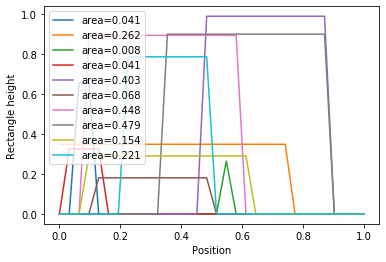

In [5]:
plot_rectangle(tr_x, tr_y, 10)

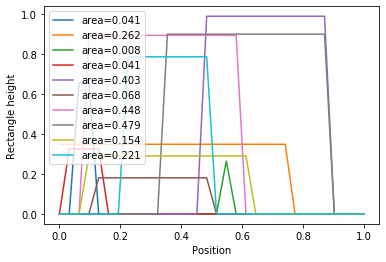

In [6]:
plot_rectangle(ts_x, ts_y, 10)

学習用コード

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, classification=False):
        self.x = x.astype('float32')[:, None, :]

        if y is not None:
            if classification:
                self.y = np.digitize(y[:,0], bins=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).astype('int64')
            else:
                # regression
                self.y = y.astype('float32')
        else:
            self.y = None

        self.n = self.x.shape[0]

        return

    def __getitem__(self, idx):
        x = self.x[idx]
        if self.y is not None:
            y = self.y[idx]
            return x, y
        else:
            return x

    def __len__(self):
        return self.n


def get_dataloader(dataset, batch_size, shuffle=True, drop_last=True, num_workers=0):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)


class Trainer:
    def __init__(self):
        return

    def run(self, model, tr_loader, vl_loader, epochs, dev, classification=False, montecalro_dropout=False):
        self.dev = dev
        self.montecalro_dropout = montecalro_dropout
        self.n_montecarlo = 5

        if classification:
            self.criterion = nn.CrossEntropyLoss()
        else:
            self.criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        rslt = []
        for ep in tqdm(range(epochs)):
            #print('\nepoch ', ep)

            tr_loss, tr_y_true, tr_y_pred = self.run_epoch(model, optimizer, tr_loader, train=True)
            vl_loss, vl_y_true, vl_y_pred = self.run_epoch(model, None, vl_loader, train=False)
            #print(f'loss tr: {tr_loss}, ts: {vl_loss}')

            rslt.append([ep, tr_loss, vl_loss])

        rslt = pd.DataFrame(rslt, columns=['epoch', 'tr_loss', 'ts_loss'])
        return rslt, tr_y_true, tr_y_pred, vl_y_true, vl_y_pred

    def run_epoch(self, model, optimizer, loader, train=True):
        if train:
            model.train()
            optimizer.zero_grad()
        else:
            if self.montecalro_dropout:
                model.train()
            else:
                model.eval()

        total_loss = 0
        y_true = []
        y_pred = []
        for batch_idx, data in enumerate(loader):
            x = data[0].to(self.dev)
            y = data[1].to(self.dev)

            with torch.set_grad_enabled(train):
                if train or (not self.montecalro_dropout):
                    output = model(x)
                else:
                    output = []
                    for im in range(self.n_montecarlo):
                        output.append(model(x).unsqueeze(-1))
                    output = torch.mean(torch.cat(output, dim=-1), dim=-1)

                loss = self.criterion(output, y)

                if train:
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                total_loss += loss.item()

                with torch.no_grad():
                    y_true.append(y.cpu().numpy())
                    y_pred.append(output.cpu().numpy())

        # loss
        total_loss = total_loss / (batch_idx + 1)
        # pred
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)

        return total_loss, y_true, y_pred


def train(model, epochs, batch_size, dev, y_scale=1, montecalro_dropout=False):
    model.to(dev)

    tr_dl = get_dataloader(Dataset(tr_x, tr_y * y_scale, model.classification), batch_size, True, True, 0)
    ts_dl = get_dataloader(Dataset(ts_x, ts_y * y_scale, model.classification), batch_size, False, False, 0)

    trainer = Trainer()
    result, tr_y_true, tr_y_pred, ts_y_true, ts_y_pred = trainer.run(model, tr_dl, ts_dl, epochs, dev, model.classification, montecalro_dropout)
    return result, tr_y_true, tr_y_pred, ts_y_true, ts_y_pred

In [8]:
dev = 'cuda'
epochs = 300
batch_size = 128

モデル  
- 1D CNN (conv, relu, maxpooling, global average pooling, linear, dropoutで構成)

In [9]:
def get_act(act):
    if act == 'relu':
        return nn.ReLU()
    elif act == 'selu':
        return nn.SELU()
    else:
        return None


def get_dropout(drp, drop_rate):
    if drp == 'dropout':
        return nn.Dropout(drop_rate)
    elif drp == 'gaussian':
        return GaussianDropout(drop_rate)
    elif drp == 'uniform':
        return UniformDropout(drop_rate)
    elif drp == 'alpha':
        return nn.AlphaDropout(drop_rate)
    else:
        return None


class GaussianDropout(nn.Module):
    """
    http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf
    https://keras.io/ja/layers/noise/
    """
    def __init__(self, p):
        super(GaussianDropout, self).__init__()
        self.sigma = np.sqrt(p / (1 - p))

    def forward(self, x):
        if self.training:
            noise = torch.randn(x.size()).to(x.device) * self.sigma
            return x * (1 + noise)
        else:
            return x


class UniformDropout(nn.Module):
    """
    https://arxiv.org/pdf/1801.05134.pdf
    """
    def __init__(self, p):
        super(UniformDropout, self).__init__()
        self.beta = p

    def forward(self, x):
        if self.training:
            noise = torch.rand(*x.size()).to(x.device) * self.beta * 2 - self.beta
            return x * (1 + noise)
        else:
            return x
            

class CNN(nn.Module):
    def __init__(self, conv_act='relu', conv_dropout=0.0, head_dropout=0.0, drp='dropout', multi_in_head=False, head_act='relu', expected_value_head=False, classification=False):
        super(CNN, self).__init__()
        self.expected_value_head = expected_value_head
        self.classification = classification

        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 8, 3, padding=1), 
            get_act(conv_act), 
            get_dropout(drp, conv_dropout),
            nn.MaxPool1d(2, 2), 
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(8, 16, 3, padding=1), 
            get_act(conv_act), 
            get_dropout(drp, conv_dropout),
            nn.MaxPool1d(2, 2), 
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(16, 32, 3, padding=1), 
            get_act(conv_act), 
            get_dropout(drp, conv_dropout),
            nn.MaxPool1d(2, 2), 
        )

        self.pooling = nn.AdaptiveAvgPool1d(1)

        if self.expected_value_head:
            self.n = 5
        elif self.classification:
            self.n = 10
        else:
            self.n = 1

        if multi_in_head:
            self.head = nn.Sequential(
                get_dropout(drp, head_dropout),
                nn.Linear(32, 32),
                get_act(head_act),
                nn.Linear(32, self.n)
            )
        else:
            self.head = nn.Sequential(
                get_dropout(drp, head_dropout),
                nn.Linear(32, self.n)
            )

        # 期待値計算用。予測対象の想定される最小値-α、最大値+α
        self.min_v = -0.2
        self.max_v = 1.2

    def forward(self, x):
        h = self.conv1(x)
        h = self.conv2(h)
        h = self.conv3(h)

        h = self.pooling(h).squeeze(2)
        h = self.head(h)

        if self.expected_value_head:
            h = self.expected_value(h)

        return h

    def expected_value(self, x):
        """
        Args:
            x: (batch, n)
        """
        # 各要素の値
        v = torch.linspace(0, 1, steps=x.size()[1]).to(x.device).unsqueeze(0) # 0 ~ 1, (1, n)
        v = v * (self.max_v - self.min_v) + self.min_v # min_v ~ max_v, (1, n)

        h = F.softmax(x, dim=1) # 各要素の確率
        h = torch.sum(v * h, dim=1, keepdim=True) # 期待値
        return h

結果可視化用

In [10]:
def plot_result(result, tr_y_true, tr_y_pred, ts_y_true, ts_y_pred, filename):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    ax = axs[0]
    result.plot(x='epoch', logy=True, ax=ax)

    if len(tr_y_true.shape) > 1:
        # regression
        ax = axs[1]
        ax.plot(tr_y_true[:,0], tr_y_true[:,0], label='Ground truth', c='black')
        ax.scatter(tr_y_true[:,0], tr_y_pred[:,0], label='Train', alpha=0.5)
        ax.scatter(ts_y_true[:,0], ts_y_pred[:,0], label='Test', alpha=0.5)
        ax.set_xlabel('Target')
        ax.set_ylabel('Predicted')
        ax.legend(loc='upper left')
    else:
        # classification
        tr_max = np.max(tr_y_pred, axis=1)
        ts_max = np.max(ts_y_pred, axis=1)

        _min = min([np.min(tr_max), np.min(ts_max)])
        _max = min([np.max(tr_max), np.max(ts_max)])
        bins = np.linspace(-_min, _max, 50)

        ax = axs[1]
        ax.hist(tr_max, bins, alpha=0.5, label='Train')        
        ax.hist(ts_max, bins, alpha=0.5, label='Test')        
        ax.set_xlabel('Max logit')
        ax.set_ylabel('Freq.')
        ax.legend(loc='upper left')

    fig.savefig(filename + '.png')
    plt.show()


dropoutなしのベース条件
- 学習もテストも問題なし

100%|██████████| 300/300 [00:23<00:00, 12.62it/s]


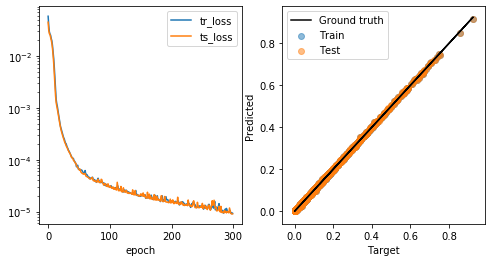

In [11]:
cnn = CNN(conv_act='relu', conv_dropout=0.0, head_dropout=0.0, multi_in_head=False, head_act='relu')
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'base')

headの直前のdropoutあり
- 学習もテストも問題なし

100%|██████████| 300/300 [00:22<00:00, 13.26it/s]


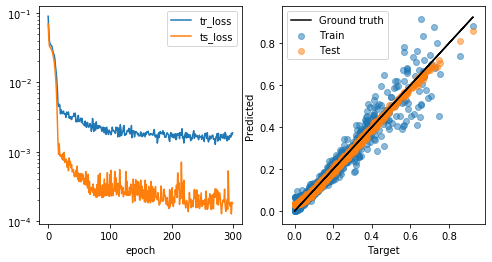

In [12]:
cnn = CNN(conv_act='relu', conv_dropout=0.0, head_dropout=0.3, multi_in_head=False, head_act='relu')
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'headdo')

headの直前のdropoutあり、期待値計算
- 学習もテストも問題なし

100%|██████████| 300/300 [00:22<00:00, 13.19it/s]


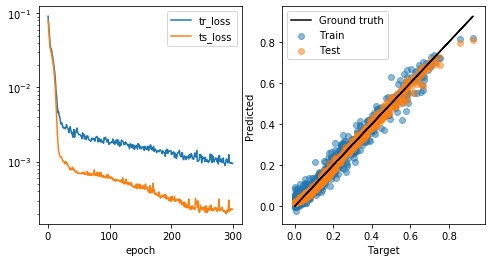

In [13]:
cnn = CNN(conv_act='relu', conv_dropout=0.0, head_dropout=0.3, multi_in_head=False, head_act='relu', expected_value_head=True)
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'headdo_ev')

headの直前のdropoutあり、head内にReLUあり
- テストでは正解値が大きいときに推定値<正解値

100%|██████████| 300/300 [00:23<00:00, 12.91it/s]


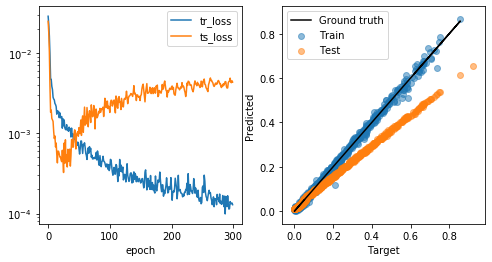

In [14]:
cnn = CNN(conv_act='relu', conv_dropout=0.0, head_dropout=0.3, multi_in_head=True, head_act='relu')
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'headdo_mhead')

headの直前のdropoutあり、head内にReLUあり、GaussianDropout
- テストでは正解値が大きいときに推定値<正解値。Dropoutよりはよい。

100%|██████████| 300/300 [00:26<00:00, 11.43it/s]


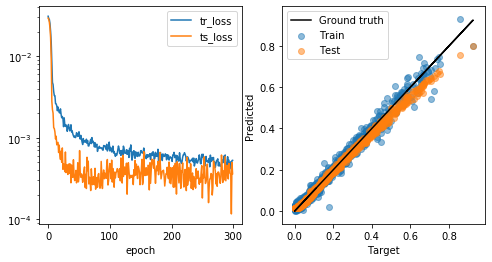

In [15]:
cnn = CNN(conv_act='relu', conv_dropout=0.0, head_dropout=0.3, drp='gaussian', multi_in_head=True, head_act='relu')
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'headdo_gaussiano_mhead')

headの直前のdropoutあり、head内にReLUあり、UniformDropout
- 学習もテストも問題なし。

100%|██████████| 300/300 [00:26<00:00, 11.21it/s]


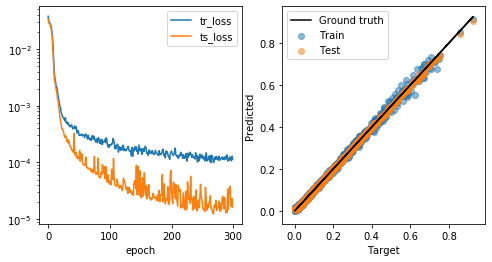

In [16]:
cnn = CNN(conv_act='relu', conv_dropout=0.0, head_dropout=0.3, drp='uniform', multi_in_head=True, head_act='relu')
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'headdo_uniformo_mhead')

headの直前のdropoutあり、head内にReLUあり、AlphaDropout
- テストでは正解値が大きいときに推定値>正解値。Dropoutよりはよい。

100%|██████████| 300/300 [00:23<00:00, 12.62it/s]


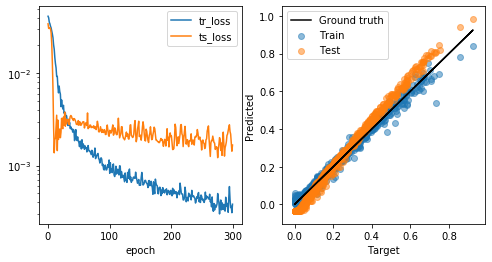

In [17]:
cnn = CNN(conv_act='relu', conv_dropout=0.0, head_dropout=0.3, drp='alpha', multi_in_head=True, head_act='relu')
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'headdo_alpha_mhead')

headの直前のdropoutあり、head内にReLUあり、期待値計算
- テストでは正解値が大きいときに推定値<正解値

100%|██████████| 300/300 [00:24<00:00, 12.08it/s]


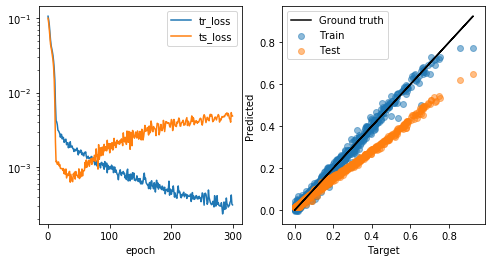

In [18]:
cnn = CNN(conv_act='relu', conv_dropout=0.0, head_dropout=0.3, multi_in_head=True, head_act='relu', expected_value_head=True)
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'headdo_mhead_ev')

conv内にdropoutあり
- テストでは正解値が大きいときに顕著に推定値<正解値

100%|██████████| 300/300 [00:21<00:00, 13.86it/s]


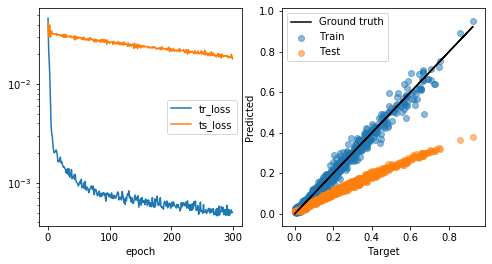

In [19]:
cnn = CNN(conv_act='relu', conv_dropout=0.3, head_dropout=0.0, multi_in_head=False, head_act='relu')
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'convdo')

conv内にdropoutあり、GaussianDropout
- テストでは正解値が大きいときに顕著に推定値<正解値。Dropoutよりはよい。

100%|██████████| 300/300 [00:26<00:00, 11.38it/s]


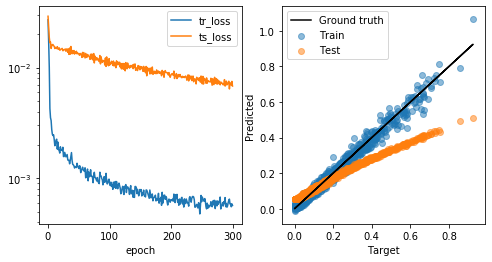

In [20]:
cnn = CNN(conv_act='relu', conv_dropout=0.3, head_dropout=0.0, drp='gaussian', multi_in_head=False, head_act='relu')
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'convdo_gaussian')

conv内にdropoutあり、UniformDropout
- テストでは正解値が大きいときに顕著に推定値<正解値。Dropout, GaussianDropoutよりはよい。

100%|██████████| 300/300 [00:26<00:00, 11.46it/s]


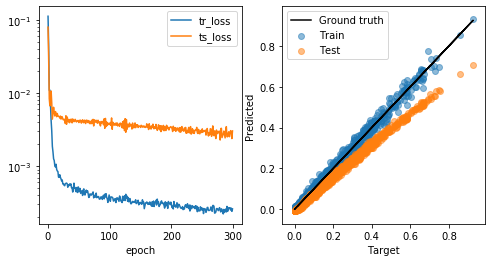

In [21]:
cnn = CNN(conv_act='relu', conv_dropout=0.3, head_dropout=0.0, drp='uniform', multi_in_head=False, head_act='relu')
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'convdo_uniform')

conv内にdropoutあり、AlphaDropout
- テストでは正解値が大きいときに推定値>正解値。Dropoutよりはよい？

100%|██████████| 300/300 [00:22<00:00, 13.43it/s]


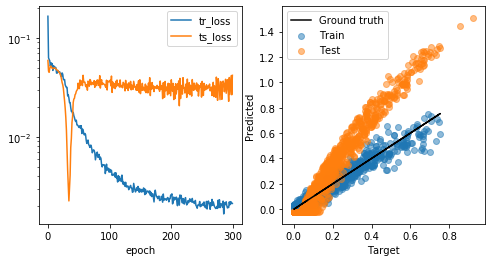

In [22]:
cnn = CNN(conv_act='relu', conv_dropout=0.3, head_dropout=0.0, drp='alpha', multi_in_head=False, head_act='relu')
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'convdo_alpha')

conv内にdropoutあり、MontecarloDropout
- 学習もテストも問題なし。

100%|██████████| 300/300 [00:33<00:00,  8.89it/s]


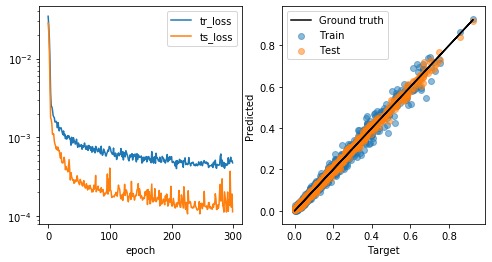

In [23]:
cnn = CNN(conv_act='relu', conv_dropout=0.3, head_dropout=0.0, multi_in_head=False, head_act='relu')
rslts = train(cnn, epochs, batch_size, dev, montecalro_dropout=True)
plot_result(*rslts, 'convdo_montecalro')

headの直前のdropoutあり(drop rate大)
- テストでは正解値が大きいときに推定値<正解値。

100%|██████████| 300/300 [00:21<00:00, 14.16it/s]


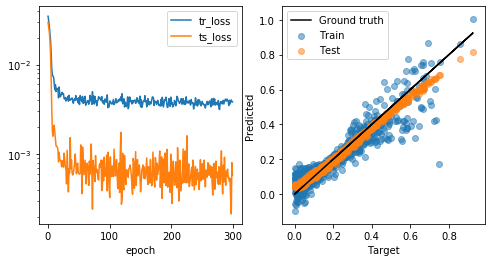

In [24]:
cnn = CNN(conv_act='relu', conv_dropout=0.0, head_dropout=0.6, multi_in_head=False, head_act='relu')
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'high-headdo')

headの直前のdropoutあり(drop rate大), GaussianDropout
- テストでは正解値が大きいときに推定値<正解値。Dropoutと大して変わらない。

100%|██████████| 300/300 [00:24<00:00, 12.49it/s]


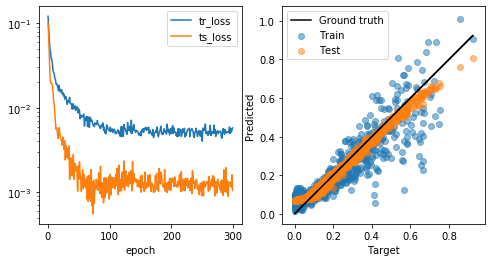

In [25]:
cnn = CNN(conv_act='relu', conv_dropout=0.0, head_dropout=0.6, drp='gaussian', multi_in_head=False, head_act='relu')
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'high-headdo_gaussian')

headの直前のdropoutあり(drop rate大), UniformDropout
- テストでは正解値が大きいときに推定値<正解値。Dropout、GaussianDropoutより良い。

100%|██████████| 300/300 [00:24<00:00, 12.28it/s]


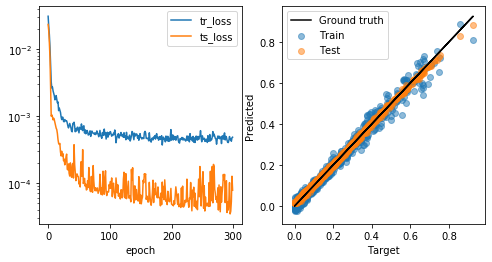

In [26]:
cnn = CNN(conv_act='relu', conv_dropout=0.0, head_dropout=0.6, drp='uniform', multi_in_head=False, head_act='relu')
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'high-headdo_uniform')

分類問題
- 学習もテストも問題なし

100%|██████████| 300/300 [00:21<00:00, 14.02it/s]


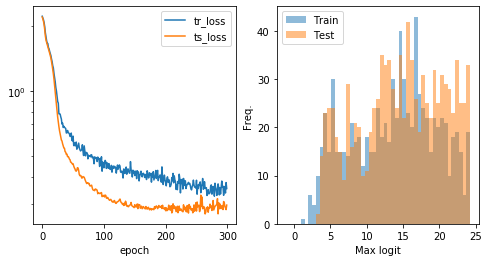

In [27]:
cnn = CNN(conv_act='relu', conv_dropout=0.0, head_dropout=0.3, multi_in_head=True, head_act='relu', classification=True)
rslts = train(cnn, epochs, batch_size, dev)
plot_result(*rslts, 'classification')